MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: June 30, 2021<br>
Last Update: December 12, 2021<br><br>

**Label: Final Workflow, Script 6**<br>

Script Purpose:<br>
Script for analyzing uncertainty in results based on four models
<br><br>


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [2]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
#!pip install dataprep --no-binary dataprep

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ge

Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

from pathlib import Path
import pickle as pkl

from scipy import stats
import math

import geopandas as gpd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Set seed for randomized elements in script

In [6]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

Helper Functions

In [54]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    #ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    grayval = 255 #200
    ax.background_patch.set_facecolor((grayval/255, grayval/255, grayval/255))
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', 
                   #edgecolor='r', linewidth=2, alpha = 0.5)
                   edgecolor='k', linewidth=3, alpha = .5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

Load well data

In [8]:
datafolder = Path(path) 

with open(datafolder/ "wells_shared.pkl","rb") as handle: 
#with open(datafolder/ "wellsp4_shared.pkl","rb") as handle: 
#with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

In [9]:
# get FDS to plot bielicki et al. map
with open(datafolder/ "full_shared.pkl","rb") as handle: 
  fdsdict = pkl.load(handle)

fdsdict['yc_pred'] = pd.cut(fdsdict['data']['GeothermGrad'],bins=[-999,30,40,60,9999],right=False, labels=False)

Load models from saved pickle files

In [12]:
datafolder = Path(path) 

lrfile  = "gradient_class_prediction_logreg.pkl"
dtfile  = "gradient_class_prediction_dtree.pkl"
xgbfile = "gradient_class_prediction_xgb16.pkl"
nnfile  = "gradient_class_prediction_ann.pkl"

with open(datafolder/'Models'/lrfile,"rb") as handle: 
  lrdict = pkl.load(handle)
with open(datafolder/'Models'/dtfile,"rb") as handle: 
  dtdict = pkl.load(handle)
with open(datafolder/'Models'/xgbfile,"rb") as handle: 
  xgbdict = pkl.load(handle)
with open(datafolder/'Models'/nnfile,"rb") as handle: 
  nndict = pkl.load(handle)

Plot well locations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


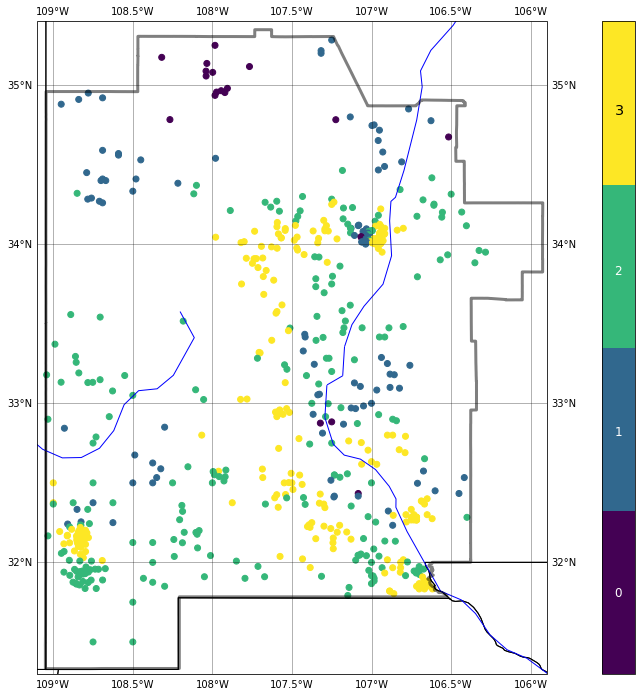

In [55]:
ax = createBasemap();
gdf = gpd.GeoDataFrame(coords, crs = {'init': 'epsg:4326'})
gdf['GeothermalClass'] = fulldf['GeothermGrad']

colmap=plt.cm.get_cmap('viridis', 4)

pc = ax.scatter(gdf.Longitude,
                gdf.Latitude,
                cmap=colmap,
                c=pd.cut(fulldf.GeothermGrad,bins=[-999,30,40,60,9999],right=False, labels=False),
                alpha=1.0,
                transform=myprojection);
gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=1, color='k', alpha=0.3, linestyle='-')
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='x-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                 fontsize='large',fontweight='extra bold')
plt.savefig(datafolder / 'Fig-GeothermGrad_input_wells_map-4classes_grid.png', bbox_inches='tight')

In [17]:
fdsdict

{'X_test':                DEM    DEMGrad  ...    Springs  GeothermGrad_2class
 4653   1932.222656  15.239053  ... -26.181908              [0, 60)
 12110  2312.285889   4.664096  ... -25.241907              [0, 60)
 14062  2288.855713   3.423762  ... -25.154249              [0, 60)
 14538  2360.535156  19.855553  ... -24.538481              [0, 60)
 6091   2789.422852  35.356083  ... -26.576344           [60, 9999)
 ...            ...        ...  ...        ...                  ...
 10241  1828.913452   1.222878  ... -24.691725              [0, 60)
 9705   2150.942627   8.189825  ... -26.031200              [0, 60)
 207    1557.289551  17.005264  ... -34.205528              [0, 60)
 4909   1937.608154  19.204470  ... -26.185059              [0, 60)
 3902   1435.599609   3.824020  ... -26.260212              [0, 60)
 
 [2252 rows x 26 columns],
 'X_train':                DEM    DEMGrad  ...    Springs  GeothermGrad_2class
 11444  2127.935791   9.593386  ... -26.145109              [0, 60

# Make Plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


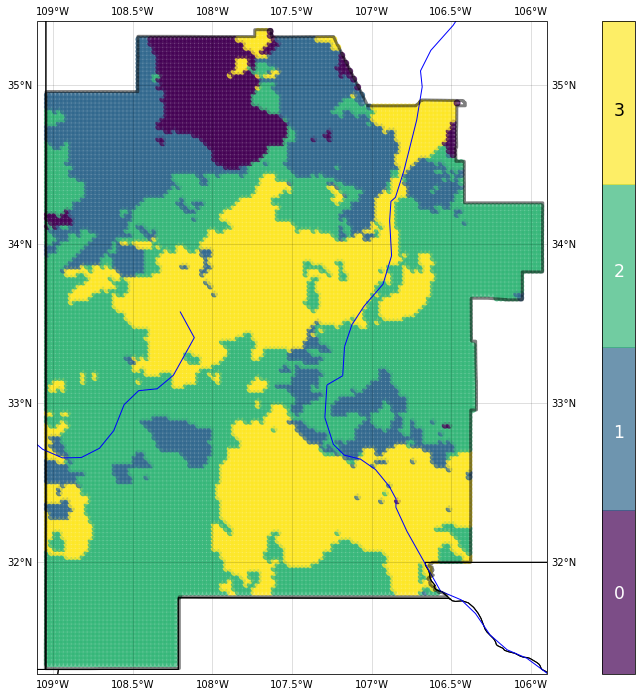

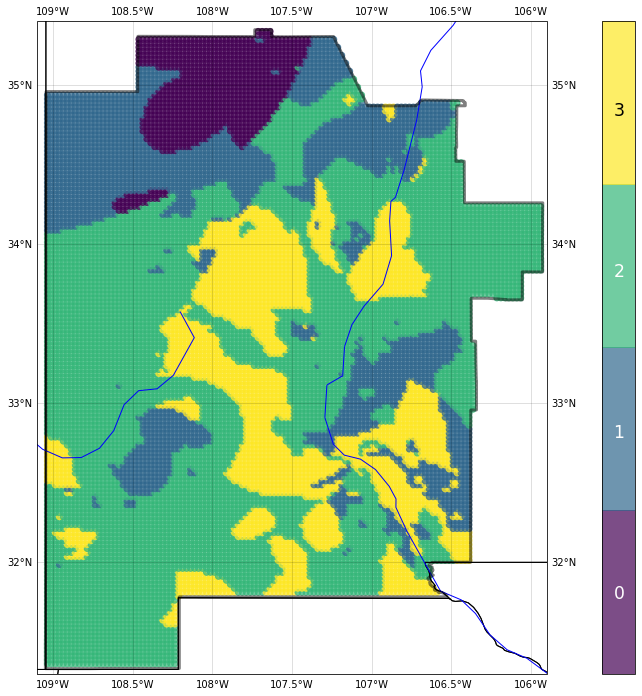

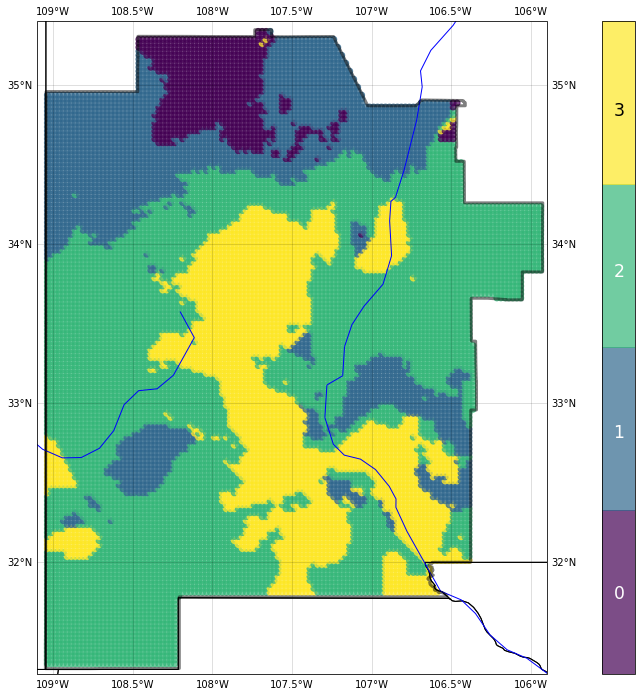

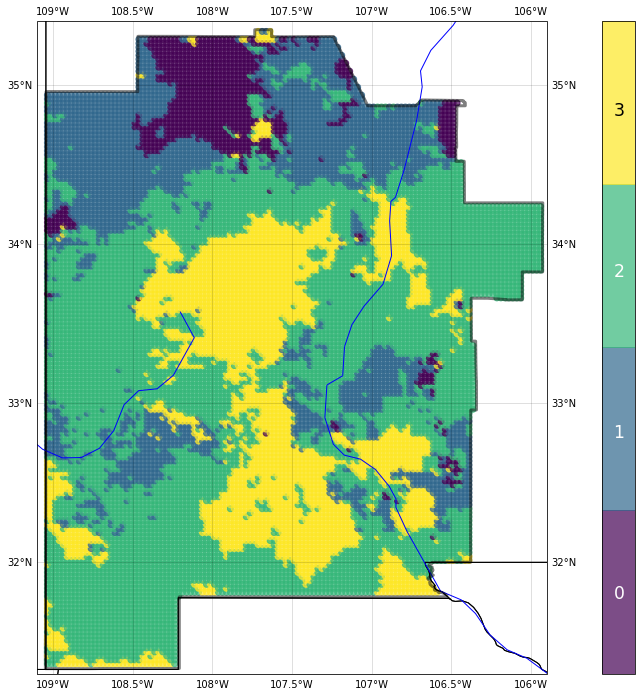

In [56]:
labels = ["Logistic Regression","Decision Tree","XGBoost","Neural Network"]#,"FDS"]
dicts  = [lrdict,dtdict,xgbdict,nndict]#,fdsdict]

colmap=plt.cm.get_cmap('viridis', 4)

for i in range(len(labels)):
  xdict=dicts[i]
  ax = createBasemap();
  gl = ax.gridlines(crs = myprojection, draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.25, linestyle='-')
  gdf = gpd.GeoDataFrame(xdict['coords'], crs = {'init': 'epsg:4326'})
  gdf['GeothermalClass'] = xdict['full_yc_pred']
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  cmap=colmap,
                  c=gdf.GeothermalClass,
                  alpha=0.7,
                  transform=myprojection);
  cbar = plt.colorbar(pc);
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
  #plt.text(-107.8,31.5,labels[i],fontsize=24)
  plt.savefig(datafolder/'Fig-PredictedModel_{}_fixedclrbar.png'.format(labels[i]), bbox_inches='tight')

In [24]:
nm = 4 # number of models
nc = 4 # number of classes
ns = len(lrdict['full_yc_pred'])
models = np.empty(shape=(nm,ns,nc))
for i in [0,1,2,3]:
  models[i] = dicts[i]['full_yc_pred_proba']

In [30]:
# Average across all probabilities
#mean_models = np.mean(models,axis=0)

# Use Distribution Summation
sum_models = np.sum(models,axis=0)
sum_models

array([[0.01073778, 0.02734667, 3.41214242, 0.54977312],
       [0.01024428, 0.026482  , 3.42333797, 0.53993569],
       [0.01064936, 0.03861475, 3.38113043, 0.56960541],
       ...,
       [1.91576662, 0.65804306, 0.40601727, 1.02017309],
       [1.95348094, 1.09444679, 0.09949933, 0.85257292],
       [1.85974537, 1.1544325 , 0.1132551 , 0.872567  ]])

In [31]:
sum_models.shape

(15007, 4)

Plot aggregate model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


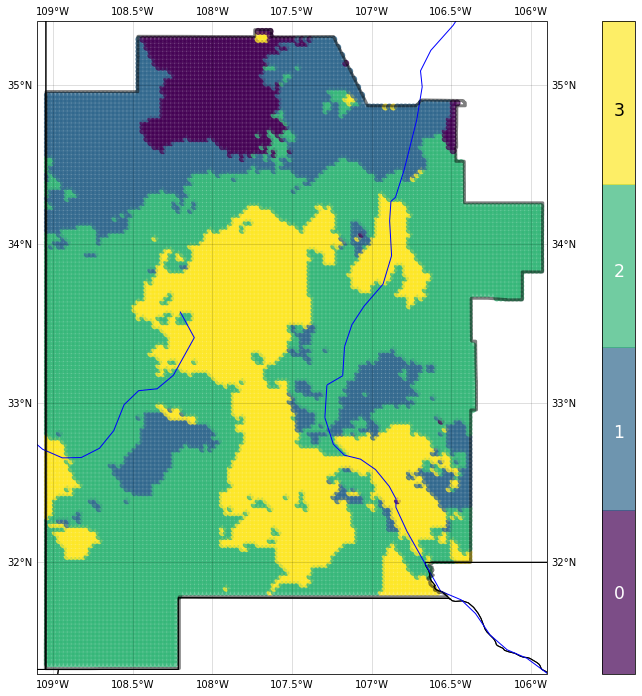

In [57]:
colmap=plt.cm.get_cmap('viridis', 4)
ax = createBasemap();
gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
pc = ax.scatter(lrdict['coords'].Longitude,
                lrdict['coords'].Latitude,
                cmap=colmap,
                c=np.argmax(sum_models,axis=1),
                alpha=0.7,
                transform=myprojection);
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')
plt.savefig(datafolder / 'Fig-DistributionSummation-RepresentationUncertainty.png', bbox_inches='tight')

### Calculate Entropy on Ensemble Model

In [32]:
# entropy as average of individual model entropies
mod_ent1 = np.empty(shape=(nm,ns))
print(mod_ent1.shape)
for i in range(nm):
  mod_ent1[i,:] = stats.entropy(models[i],base=4,axis=-1).squeeze()
mod_ent1 = np.mean(mod_ent1,axis=0)

# entropy from distribution summation
mod_ent2 = stats.entropy(sum_models,base=2,axis=-1)/math.log(nc,2)

(4, 15007)


### Calculate Entropy as point entropy of average of model class probabilities

### Plot results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


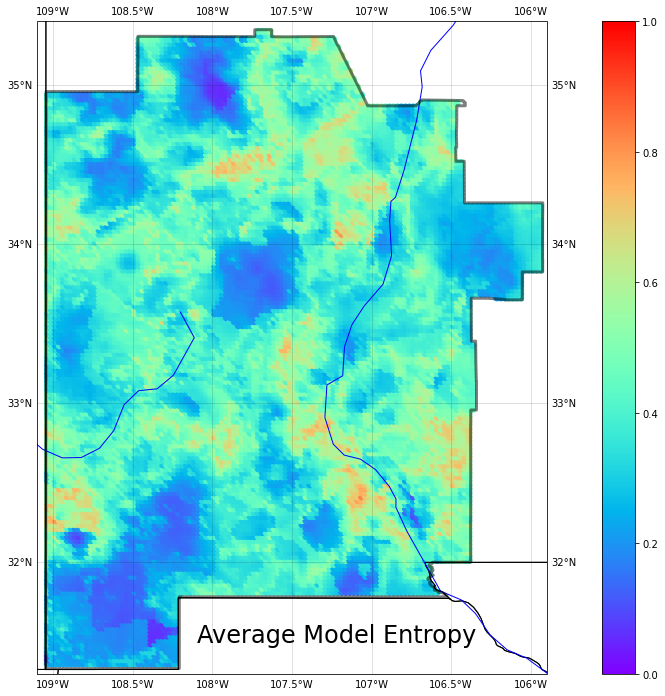

<Figure size 432x288 with 0 Axes>

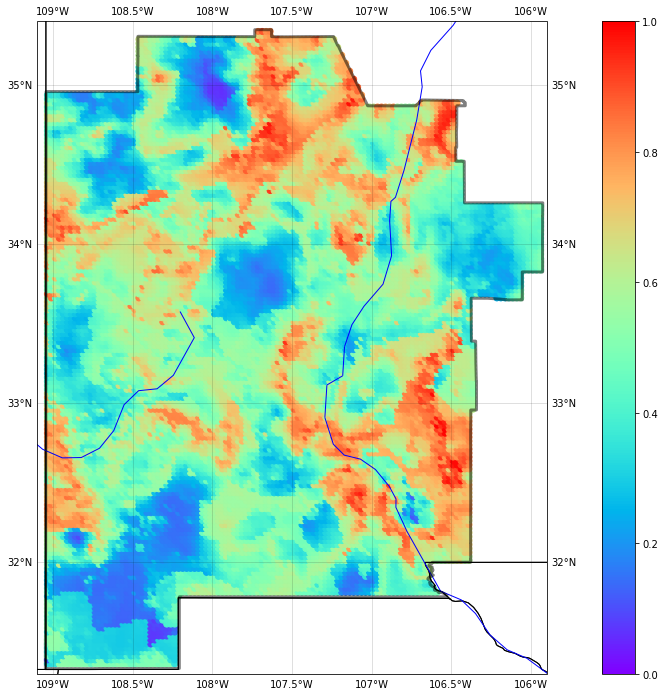

In [58]:
ax = createBasemap();
gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
pc = ax.scatter(dicts[0]['coords'].Longitude,
                dicts[0]['coords'].Latitude,
                cmap='rainbow',
                c=mod_ent1,
                alpha=1.,
                vmin=0.0,
                vmax=1.0,
                transform=myprojection);
cbar = plt.colorbar(pc);
plt.text(-108.1,31.5,"Average Model Entropy",fontsize=24);

plt.figure()
ax = createBasemap();
gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
pc = ax.scatter(dicts[0]['coords'].Longitude,
                dicts[0]['coords'].Latitude,
                cmap='rainbow',
                c=mod_ent2,
                alpha=1.,
                vmin=0.0,
                vmax=1.0,
                transform=myprojection);
plt.colorbar(pc);
#plt.text(-108.1,31.5,"Entropy of Averages",fontsize=24);
plt.savefig(datafolder/'Fig-Entropy_RepresentationUncertainty.png', bbox_inches='tight')

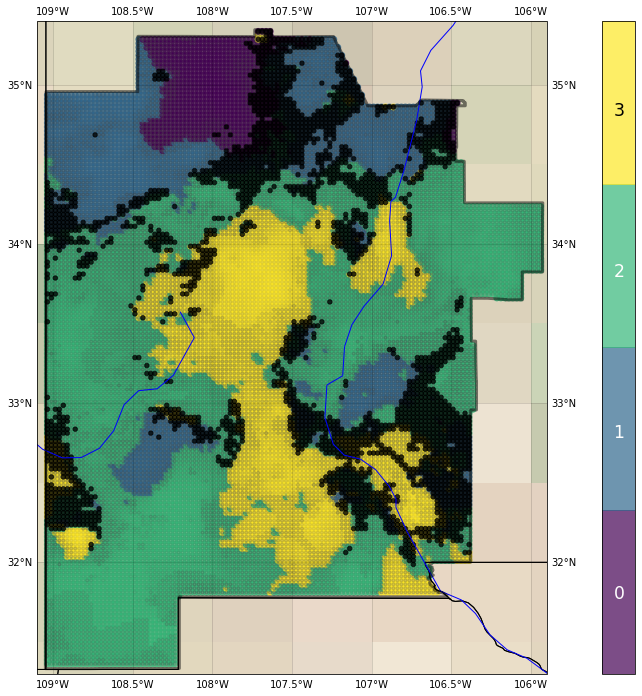

In [59]:
mask = True
# create base image for map
expl_area = datafolder / 'Exploration_area.shp'
expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
plt.figure(figsize=(20,12))
ax = plt.axes(projection=myprojection)
ax.stock_img()
    
ax.add_feature(cartopy.feature.STATES)
ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
ax.add_feature(expl_area_feat, facecolor='None', edgecolor='k', linewidth=3, alpha = 0.5)
ax.set_extent(extent,crs=myprojection)

gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
colmap=plt.cm.get_cmap('viridis', 4)

rgba_colors = np.zeros((len(mod_ent2),4))
rgba_colors[:,0] = rgba_colors[:,1] = rgba_colors[:,2] = 0.0

pc = ax.scatter(dicts[0]['coords'].Longitude,
                dicts[0]['coords'].Latitude,
                cmap=colmap,
                c=np.argmax(sum_models,axis=1),
                alpha=.7, #s= 20,
                transform=myprojection);
cbar = plt.colorbar(pc)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')
if mask == True:
  # add alpha values
  rgba_colors[:, 3] = [0 if x<0.7 else .8 for x in mod_ent2]
  pc = ax.scatter(dicts[0]['coords'].Longitude,
                  dicts[0]['coords'].Latitude,
                  s = 20,
                  color=rgba_colors,
                  transform=myprojection);

  rgba_colors[:,0] = rgba_colors[:,1] = rgba_colors[:,2] = 0.25
  rgba_colors[:, 3] = [0 if x>0.7 else x/2 for x in mod_ent2]
  pc = ax.scatter(dicts[0]['coords'].Longitude,
                  dicts[0]['coords'].Latitude,
                  s = 10,
                  color=rgba_colors,
                  transform=myprojection);

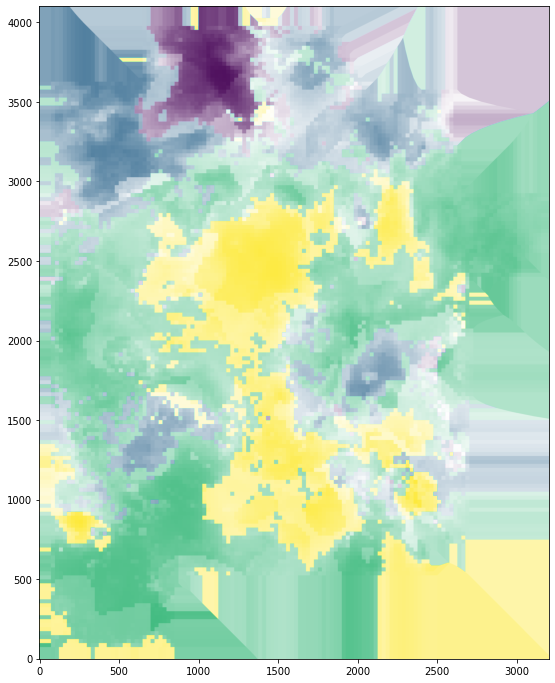

In [60]:
from scipy.interpolate import griddata
nmap=3
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
numx = int(((xmax-xmin)/.001) +1)
numy = int(((ymax-ymin)/.001) +1)

xi = np.linspace(xmin,xmax,numx)
yi = np.linspace(ymin,ymax,numy)
zi = griddata((dicts[nmap]['coords'].Longitude,dicts[nmap]['coords'].Latitude),dicts[nmap]['full_yc_pred'], (xi[None,:], yi[:,None]),method='nearest')
ai = griddata((dicts[nmap]['coords'].Longitude,dicts[nmap]['coords'].Latitude),1-mod_ent2, (xi[None,:], yi[:,None]),method='nearest')

plt.figure(figsize=(20,12))
plt.imshow(zi,cmap='viridis',vmin=0,vmax=3,alpha=ai)
plt.gca().invert_yaxis()

In [61]:
from scipy.interpolate import griddata
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
numx = int(((xmax-xmin)/.025) +1)
numy = int(((ymax-ymin)/.025) +1)
xi = np.linspace(xmin,xmax,numx)
yi = np.linspace(ymin,ymax,numy)
grid_x, grid_y = np.meshgrid(xi,yi)
zi = griddata((dicts[nmap]['coords'].Longitude,dicts[nmap]['coords'].Latitude),np.argmax(sum_models,axis=1), (xi[None,:], yi[:,None]),method='nearest')
ai = griddata((dicts[nmap]['coords'].Longitude,dicts[nmap]['coords'].Latitude),1-mod_ent2, (xi[None,:], yi[:,None]),method='nearest')

In [62]:
gdf = gpd.GeoDataFrame({"Longitude":grid_x.reshape(-1,1).squeeze(), 
                        "Latitude":grid_y.reshape(-1,1).squeeze(), 
                        "GeothermalClass":zi.reshape(-1,1).squeeze(), 
                        "Unentropy":ai.reshape(-1,1).squeeze()},
                       crs = {'init': 'epsg:4326'})
gdf['geometry']=gpd.points_from_xy(gdf.Longitude,gdf.Latitude)
for p in expl_area_feat.geometries():
  break;
  
gdf=gpd.clip(gdf,p)

### Build transparency into colors for map

In [63]:
mpl.__version__

norm = mpl.colors.Normalize(vmin=0.0, vmax=3.0)
cmap = mpl.cm.get_cmap('viridis',4)

colors = [cmap(norm(c), alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]
colors = [cmap(c, alpha=a**1.5) for c,a in zip(gdf.GeothermalClass.to_list(),gdf.Unentropy.to_list())]
print(colors)

[(0.190631, 0.407061, 0.556089, 0.12631550944370706), (0.190631, 0.407061, 0.556089, 0.08852907082776254), (0.190631, 0.407061, 0.556089, 0.29533826259935103), (0.190631, 0.407061, 0.556089, 0.07564291037337527), (0.190631, 0.407061, 0.556089, 0.2959573028417988), (0.190631, 0.407061, 0.556089, 0.16855541611225824), (0.190631, 0.407061, 0.556089, 0.21202084069371951), (0.190631, 0.407061, 0.556089, 0.25565775721974227), (0.190631, 0.407061, 0.556089, 0.18524470987025055), (0.190631, 0.407061, 0.556089, 0.24937968622506027), (0.190631, 0.407061, 0.556089, 0.1049300104631812), (0.190631, 0.407061, 0.556089, 0.301404980947847), (0.190631, 0.407061, 0.556089, 0.08502731980519589), (0.190631, 0.407061, 0.556089, 0.1254596233484029), (0.190631, 0.407061, 0.556089, 0.16343557221283733), (0.190631, 0.407061, 0.556089, 0.2814702980241761), (0.190631, 0.407061, 0.556089, 0.28337434268308587), (0.190631, 0.407061, 0.556089, 0.2315744648318085), (0.190631, 0.407061, 0.556089, 0.2725278903991901), 

### Plot classes with transparency + optional black mask for entropy values > threshold (0.7)

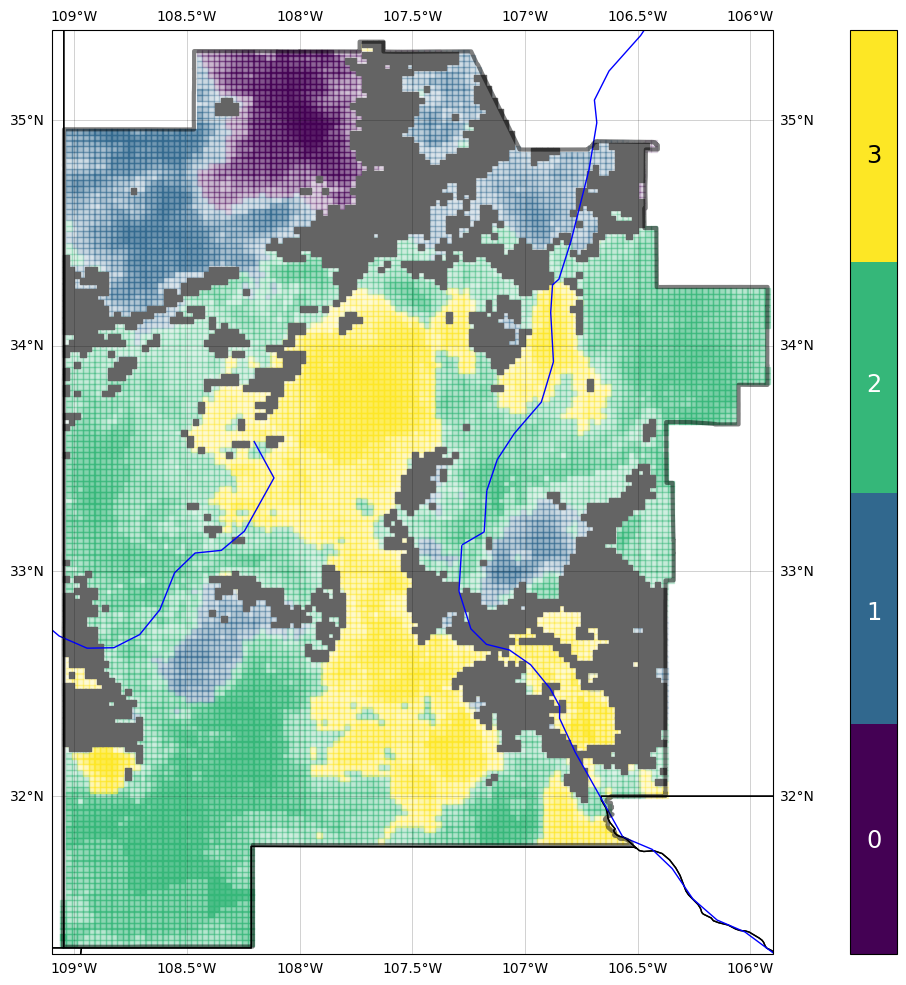

In [65]:
mask = True
# create base image for map
expl_area = datafolder / 'Exploration_area.shp'
expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

with mpl.style.context('default'):
  plt.figure(figsize=(20,12))
  ax = plt.axes(projection=myprojection)
  #ax.stock_img()
  
  #grayval = 200
  #ax.add_feature(expl_area_feat, facecolor='w', edgecolor='None', alpha = 1)
  #ax.background_patch.set_facecolor((grayval/255, grayval/255, grayval/255))
  ax.add_feature(cartopy.feature.STATES)
  ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
  ax.add_feature(expl_area_feat, facecolor='None', edgecolor='k', linewidth=3, alpha = 0.5)
  ax.set_extent(extent,crs=myprojection)

  # plot lat/lon grid 
  gl = ax.gridlines(crs = myprojection, draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.25, linestyle='-')
  
  # plot zero-sized symbols to establish colorbar
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  cmap = cmap,
                  alpha=1,
                  c=gdf.GeothermalClass,
                  s=0,
                  transform=myprojection)
  cbar = plt.colorbar(pc)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
      
  # plot actual symbols with transparency
  pc = ax.scatter(gdf.Longitude,
                  gdf.Latitude,
                  c=colors,
                  marker='s',
                  s=18,
                  transform=myprojection)
  if mask == True:

  # add black-out
  #masked_colors = [c if c[-1]>(0.3**2) else (64,64,64,1) for c in rgba_colors ]
  
    rgba_colors = np.zeros((len(mod_ent2),4))
    rgba_colors[:,0] = [0 if x<0.7 else 100/256 for x in mod_ent2]
    rgba_colors[:,1] = [0 if x<0.7 else 100/256 for x in mod_ent2]
    rgba_colors[:,2] = [0 if x<0.7 else 100/256 for x in mod_ent2]
    rgba_colors[:, 3] = [0 if x<0.7 else 1 for x in mod_ent2]
    pc = ax.scatter(dicts[0]['coords'].Longitude,
                    dicts[0]['coords'].Latitude,
                    marker='s',
                    s = 18,
                    color=rgba_colors,
                    transform=myprojection);

plt.savefig(datafolder / 'Fig-Masked_RepresentationUncertainty.png', bbox_inches='tight')